# [RAG - Part 1](https://python.langchain.com/docs/tutorials/rag/)


* `Part 1` : **simple Q&A application** over **unstructured data**
* `Part 2` : extends to accommodate **conversation-style interactions** & **multi-step retrieval** processes
  * typical Q&A architecture
  * additional resources for more advanced Q&A techniques

In [27]:
###############
### ~Setup~ ###
###############

import os
from dotenv import load_dotenv

# Load secrets from file
with open('secrets.txt') as f:
    for line in f:
        if '=' in line:
            key, value = line.strip().split('=', 1)
            os.environ[key] = value

# Initialize LangChain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

RAG has 2 parts:

1. Indexing: pipeline for ingesting data from source & indexing it (usually happens offline)

2. Retrieval & generation: actual **RAG chain**: 
   * takes user query at run time
   * retrieves  relevant data from index 
   * passes that to `model`

> ℹ **Note**: indexing portion of this tutorial will largely follow the `3_retreivers.ipynb`

Most common full sequence from raw data to answer:

#### 1️⃣ Indexing
--
1. **Load**: Done with [Document Loaders](https://python.langchain.com/docs/concepts/document_loaders/).
2. **Split**: [Text splitters](https://python.langchain.com/docs/concepts/text_splitters/) breaks large Documents into smaller chunks. Useful both for indexing data & passing it into model: **large chunks are harder to search over & won't fit in a model's finite context window**
3. **Store**: Need somewhere to store & index our splits, so that they can be searched over later. Often done usin [VectorStore](https://python.langchain.com/docs/concepts/vectorstores/) & [Embeddings models](https://python.langchain.com/docs/concepts/embedding_models/).

![Image URL](https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png)

#### 2️⃣ Retreival & Generation
---
4. Retrieve: Given a user input, relevant splits are retrieved from storage using a [Retriever](https://python.langchain.com/docs/concepts/retrievers/)
5. Generate: A [ChatModel](https://python.langchain.com/docs/concepts/chat_models/) / [LLM](https://python.langchain.com/docs/concepts/text_llms/) **produces an answer** using prompt that includes **both the question with retrieved data**
![Image URL](https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png)

> Once *data indexed*, we will use `LangGraph` as **orchestration framework** to RAG steps.

> #### `InMemoryVectorStore`

In [28]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Preview

Build app that answers questions about the website's content
Specific website: [**LLM Powered Autonomous Agents blog post by Lilian Weng**](https://lilianweng.github.io/posts/2023-06-23-agent/) → ask questions about the contents

> **Simple indexing pipeline & RAG chain in ~50 lines of code**

> **API Reference**: [`hub`]() | [`WebBaseLoader`]() | [`Document`]() | [`RecursiveCharacterTextSplitter`]() | [`StateGraph`]()

In [29]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200)

all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Define application steps


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [30]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down complex tasks into smaller, more manageable steps, often using techniques like Chain of Thought (CoT) and Tree of Thoughts. This helps models plan effectively and think step by step, improving their performance on difficult tasks. It can be facilitated through simple prompts, task-specific instructions, or human inputs.


## Detailed walkthrough

## 1. Indexing

> Abbreviated version of `3_retreiver.ipynb`

#### Loading documents
* Load blog post contents
* [`DocumentLoaders`]() are objects that load in data from source returing list of [`Document`]() objects
  * In this example, [`WebBaseLoader`]() uses `urllib` to load HTML from web URL & `BeautifulSoup` to parse it to text
  * Customize HTML parsing in param in BS `BeautifulSoup` parser `bs_kwargs`
  * In this example, only HTML tags with class `“post-content”`, `“post-title”`, or `“post-header”` relevant, so we’ll remove all others

> **API Ref** [`WebBaseLoader`]()

In [31]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(
    class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [32]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

`DocumentLoader`: Object that loads data from a source as list of Documents.

* [Docs](https://python.langchain.com/docs/how_to/#document-loaders): Detailed documentation on how to use DocumentLoaders.
* [Integrations](https://python.langchain.com/docs/integrations/document_loaders/): 160+ integrations to choose from.
* [Interface](https://python.langchain.com/docs/tutorials/rag/#:~:text=160%2B%20integrations%20to%20choose%20from.-,Interface,-%3A%20API%20reference%20for%20the%20base): API reference for the base interface.

### Splitting documents

* Loaded document > 42k characters → too long for context window
* Even models that fit full post in context window, **models struggle to find information in long inputs**
* →  split `Document` into chunks for embedding & vector storage
  * Should help retreive only most relevant parts of blog post at run time

As in `3_retreivers.ipynb` use `RecursiveCharacterTextSplitter` 
    * --> Recursively split document using common separators (new lines etc) until each chunk is  appropriate size (recommended text splitter for generic text use cases)

In [33]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


> #### **Go deeper**
>
>`TextSplitter`: Object that splits list of >`Documents` into smaller chunks. Subclass of >`DocumentTransformers`.
>
>Learn more about splitting text using different methods by reading the [how-to docs](https://python.langchain.com/docs/how_to/#text-splitters)
>* [Code (`py` or `js`)](https://python.langchain.com/docs/integrations/document_loaders/source_code/)
>* [Scientific papers](https://python.langchain.com/docs/integrations/document_loaders/grobid/)
>* [Interface](https://python.langchain.com/api_reference/text_splitters/base/langchain_text_splitters.base.TextSplitter.html): API reference for the base interface
>
>`DocumentTransformer`: Object that performs a **transformation on a list of Document objects**.
>
>  * [Docs](https://python.langchain.com/docs/how_to/#text-splitters): Detailed documentation on how to use `DocumentTransformers`
>  * [Integrations](https://python.langchain.com/docs/integrations/document_transformers/)
>  * [Interface](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.transformers.BaseDocumentTransformer.html): API reference for the base interface.
  
### Storing documents

* Now must index 66 text chunks → search over them at runtime
* Following`3_retreivers.ipynb` → embed contents of each document split & **insert embeddings into vector store**
*  Given an input query, we can then use vector search to retrieve relevant documents.

**Can embed & store all document splits in single command using the vector store & embeddings model selected**

In [34]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['314d665d-6eb4-4014-89b5-c0e6b4864994', 'f5298e6b-3394-4716-a778-3dc3c18d78b0', '67a0afdd-1bd5-404f-aab1-33ada86c1058']


> **Go Deeper**
> `Embeddings`: Wrapper around a text embedding model, used for converting text to embeddings.
>
> * [Docs](): Detailed documentation on how to use embeddings.
> * [Integrations](): 30+ integrations to choose from.
> * [Interface](): API reference for the base interface.
>
> `VectorStore`: Wrapper around a vector database, used for storing and querying embeddings.
>
> * [Docs](https://python.langchain.com/docs/how_to/vectorstores/): Detailed documentation on how to use vector stores.
> * [Integrations](https://python.langchain.com/docs/integrations/vectorstores/): 40+ integrations to choose from.
> [Interface](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStore.html): API reference for the base interface.


**We now have query-able vector store containing chunked contents of blog post**

## 2. Retreival & Generation

* Now we write actual application logic
* Want to create simple application:
    * Take user Q
    * Searches documents relevant to Q
    * Passes retrieved documents & initial question to model → returns answer

We’ll use prompt for RAG that is checked into the [LangChain prompt hub](https://smith.langchain.com/hub/rlm/rag-prompt)

> **API Reference**:[hub](https://python.langchain.com/api_reference/langchain/hub/langchain.hub.hub.html)


In [35]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


LangGraph used to **tie together the retrieval & generation steps into a single application**: 

**Benefits:**

* Define application logic once & automatically support **multiple invocation modes**, including *streaming, async, & batched calls*
* Streamlined deployments via **LangGraph Platform**
* LangSmith **automatically traces steps of application**
* Easily add key features to our application, including **persistence** & **human-in-the-loop approval**, with minimal code changes

To use LangGraph, we need to define three things:

1. **State** of application;
2. **Nodes** of application (i.e., application steps);
3. **"Control Flow"** of application (e.g., ordering of steps)

> #### `LangGraph` requirement 1. State

* State of application controls:
  * What data input into application, 
  * What data is transferred between steps
  * What data is output by application. 
* Typically a `TypedDict`; can also be a `Pydantic BaseModel`

**Simple RAG application** → just keep track of **input question, retrieved context, & generated answer**:

> **API Reference**:[`Document`](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html)

In [36]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

> #### `LangGraph` requirement 2. Nodes (Application steps)

Simple sequence of two steps: 

1. Retrieval Step: Simply runs similarity search using input question
2. Generation Step: **Formats** retrieved context & original question into a **prompt for chat model** & generates response


In [37]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

> #### `LangGraph` requirement 3. Control Flow

* Compile application into single graph object. 
  * Here, we are just connecting retrieval & generation steps into **single sequence**

> **API Reference**:[StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph)

`LangGraph` has built-in utilities for **visualizing app control flow**

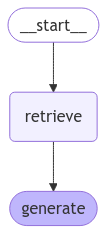

In [38]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

> #### Invoke `LangGraph` model

In [39]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='ecc49671-acbb-4a7c-976c-a6ed9028f261', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='67a0afdd-1bd5-404f-aab1-33ada86c1058', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent

> #### Streaming steps

In [40]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='ecc49671-acbb-4a7c-976c-a6ed9028f261', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='67a0afdd-1bd5-404f-aab1-33ada86c1058', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent sy

> #### Streaming tokens

In [41]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| manageable| steps| to| facilitate| easier| completion|.| This| can| be| achieved| through| techniques| like| Chain| of| Thought| (|Co|T|),| where| a| model| is| prompted| to| think| step| by| step|,| or| through| specific| instructions| and| human| inputs|.| It| enhances| model| performance| by| allowing| for| clearer| reasoning| and| planning|.||

> **ℹ️ For async invocations, use**:
> 
> `result = await graph.ainvoke(...)`
> &
> `async for step in graph.astream(...)`


> #### Returning sources
By storing retrieved context in state of graph → we recover sources for model's generated answer in the `"context"` field of the state. 
See [this guide](https://python.langchain.com/docs/how_to/qa_sources/) on returning sources for more detail.

#### **Go deeper**
[Chat models](https://python.langchain.com/docs/concepts/chat_models/) take in sequence of messages & return a message.

* [Docs](https://python.langchain.com/docs/how_to/#chat-models)
* [Integrations](https://python.langchain.com/docs/integrations/chat/): 25+ integrations to choose from.
* [Interface](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html): API reference for the base interface.

#### Customizing the prompt

* We can load prompts (e.g., this RAG prompt) from the `prompt hub`. The prompt can also be easily customized. 

> **API Reference**: [`PromptTemplate`](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html)

For example:

In [42]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [43]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [44]:
custom_rag_prompt.pretty_print()

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:


## Query analysis

* Currently using raw input query
* Advantages to allowing **model to generate query for retrieval purposes** 

For example:

* In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
* Model can **rewrite user queries** - may be multifaceted or include irrelevant language - into more effective search queries

[Query analysis](https://python.langchain.com/docs/concepts/retrieval/#query-analysis) employs **models to transform or construct optimized search queries from raw user input**

> #### Add metadata to `Documments`
* For illustrative purposes, let's **add some metadata to documents** in our vector store
* We will add some (contrived) sections to document which we can filter on later


In [45]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

* Need to update documents in vector store. 
* We will use a simple [`InMemoryVectorStore`] for this, as we will use some of its specific features (i.e., metadata filtering).* Refer to the [vector store integration documentation]() for relevant features of chosen vector store

> **API Reference**:[`InMemoryVectorStore`](https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html)

In [46]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings) # As before...
_ = vector_store.add_documents(all_splits) # As before...

* Next define a schema for search query
* Will use structured output for this 
*Here we define query as containing a string query & document section (either "beginning", "middle", or "end")

In [47]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

* Finally, add step to LangGraph application to generate a query from the user's raw input

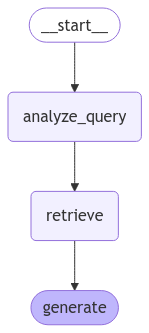

In [48]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

 * Test implementation by specifically asking for **context from end of post**
 * Note model **includes different information in its answer**

In [49]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'end of the post about Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='4e7fccea-09d7-492f-a10c-330b83e8d627', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 37914, 'section': 'end'}, page_content='"content": "Please now remember the steps:\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nFirst lay out the names of the core classes, functions, methods that will be necessary, As well as a quick comment on their purpose.\\n\\nThen you will output the content of each file including ALL code.\\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\\nFILENAME is the lowercase file name including the file extension,\\nLANG is the markup code block language for the code\'s language, and CODE is the code:\\n\\nFILENAME\\n```LANG\\nCODE\\n```\\n\\nPlease n

* In both streamed steps & LangSmith trace, we can now observe structured query fed into retrieval step

* Query Analysis is rich problem with wide range of approaches

* Refer to the [how-to guides](https://python.langchain.com/docs/how_to/#query-analysis) for more examples.

# Next Steps

We've covered the steps to build a basic Q&A app over data:

* Loading data with Document Loader
* Chunking indexed data with Text Splitter to make it easily usable by model
* Embedding data & storing data in vectorstore
* Retrieving previously stored chunks in response to incoming questions
* Generating an answer using the retrieved chunks as context.

In Part 2 of the tutorial, we will extend the implementation here to accommodate conversation-style interactions and multi-step retrieval processes.

## Further reading

* [Return sources](https://python.langchain.com/docs/how_to/qa_sources/): Learn how to return source documents
* [Streaming](https://python.langchain.com/docs/how_to/streaming/): Learn how to stream outputs and intermediate steps
* [Add chat history](https://python.langchain.com/docs/how_to/message_history/): Learn how to add chat history to your app
* [Retrieval conceptual guide](https://python.langchain.com/docs/concepts/retrieval/): A high-level overview of specific retrieval techniques